## Homework - Unit 4

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget
import zipfile

In [2]:
pd.__version__

'1.4.1'

In [3]:
data = wget.download('https://archive.ics.uci.edu/static/public/222/bank+marketing.zip')

In [43]:
# Unzip the downloaded file
with zipfile.ZipFile('bank+marketing.zip', 'r') as zip_ref:
    zip_ref.extractall('bank')

# Unzip again
with zipfile.ZipFile('bank/bank.zip', 'r') as zip_ref:
    zip_ref.extractall('bank')

In [44]:
df = pd.read_csv('bank/bank-full.csv', sep=';')
df.y = (df.y == 'yes').astype(int)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


In [45]:
base = ['age','job','marital','education','balance','housing','contact',
        'day','month','duration','campaign','pdays','previous','poutcome','y']

In [46]:
df = df[base]

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [48]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [49]:
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [50]:
len(df_train), len(df_test), len(df_val)

(27126, 9043, 9042)

In [51]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [52]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [53]:
del df_train['y']
del df_val['y']
del df_test['y']

### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [54]:
# Numerical features of the dataset
numerical = df.select_dtypes(include='int64').columns.tolist()
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [55]:
for feature in numerical:
    print(feature, roc_auc_score(df['y'], df[feature]))

age 0.4921447337528449
balance 0.590061489160812
day 0.47348006434441653
duration 0.8075955951124923
campaign 0.4276657855857303
pdays 0.593224032562116
previous 0.6023034054239005


Answer: duration

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [56]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [57]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [58]:
# q2 = accuracy_score(y_val, y_pred >= 0.5)
auc = roc_auc_score(y_val, y_pred)
round(auc, 5)

0.89996

Answer: 0.89

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

In [60]:
scores = []

thresholds = np.arange(0, 1.01, 0.01)

# Printing true positives & negatives, false positives & negatives for each rate 
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum() # true positive
    tn = (predict_negative & actual_negative).sum() # true negative

    fp = (predict_positive & actual_negative).sum() # false positive
    fn = (predict_negative & actual_positive).sum() # false negative

    p = tp / (tp + fp) # precision 
    r = tp / (tp + fn) # recall
    
    # List of tuples is created per threshold
    scores.append((t, tp, fp, fn, tn, p, r))

C:\Users\begon\AppData\Local\Temp/ipykernel_18180/2306876618.py:19: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp) # precision


In [61]:
# Creating a dataframe for these scores
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [65]:
from scipy import interpolate
from scipy.optimize import fsolve

C:\Users\begon\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


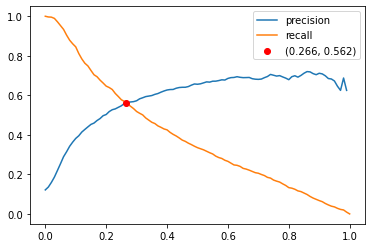

In [67]:
# Crear funciones interpoladas para f(x) y g(x)
f_interp = interpolate.interp1d(df_scores.threshold, df_scores.precision, kind='linear')
g_interp = interpolate.interp1d(df_scores.threshold, df_scores.recall, kind='linear')

def diference(x):
    return f_interp(x) - g_interp(x)

# Find where f(x) = g(x)
x_intersec = fsolve(diference, 0)[0]
y_intersec = f_interp(x_intersec)

plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.scatter(x_intersec, y_intersec, color="red", zorder=5, label=f"({x_intersec:.3f}, {y_intersec:.3f})")
plt.legend()

Answer: 0.265

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$F_1=2\cdot\frac{P\cdot R}{P+R}$

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [73]:
df_scores['F1'] = 2*df_scores.precision*df_scores.recall / (df_scores.precision+df_scores.recall)

In [76]:
indice_max = df_scores.F.idxmax()
df_scores.loc[indice_max]

threshold       0.220000
tp            691.000000
fp            620.000000
fn            407.000000
tn           7324.000000
precision       0.527079
recall          0.629326
F1              0.573682
Name: 22, dtype: float64

Answer: 0.22

### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [94]:
# Preprocessing + training of model
def train(df_train, y_train, C):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [83]:
# Prediction of y values
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [84]:
from sklearn.model_selection import KFold

In [93]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    # the k-fold split uses index to shuffle the data
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    # y values come from dataset
    y_train = df_train.y.values
    y_val = df_val.y.values
    
    # training and predicting
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    
    # AUC
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

np.std(scores)

6.931120086761666e-08

Answer: 0.0001 ?? (it does not look look)

### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [95]:
from tqdm.auto import tqdm

In [96]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        # the k-fold split uses index to shuffle the data
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
        
        # y values come from dataset
        y_train = df_train.y.values
        y_val = df_val.y.values
        
        # training and predicting
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        # AUC
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.702 +- 0.009
C=0.001 0.987 +- 0.003
C=1 1.000 +- 0.000


Answer: C=1.0